## LangGraph: Multi-Agent Workflow

This notebook will focus on the exploration of LangGraph and Agentic Workflow used by this project to achieve its image recognition and recipe creation.

In [1]:
# Important Library
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
import base64
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
from typing_extensions import TypedDict 

In [4]:
#  Load environment variables
load_dotenv()

#  Get the OpenAI API key
api_key = os.getenv("OPENAI_API_KEY")

In [5]:
#  Initialize GPT-4 Turbo
llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0.3, openai_api_key=api_key)


In [6]:
#  Define states
class OverallIngredientState(TypedDict):
    image_path: str
    ingredients: list
    filtered_ingredients: list
    preferences: list
    recipe_text: str
    
class OverallRecipeState(TypedDict):
    ingredients: list
    preferences: list
    recipe_text: str

In [7]:
#  Encode image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

#  Recognize ingredients
def recognise_ingredients(state: OverallIngredientState):
    encoded_image = encode_image(state['image_path'])
    messages = [
        {"role": "system", "content": "You are a food expert who identifies ingredients."},
        {"role": "user", "content": [
            {"type": "text", "text": "Analyze this image and list ingredients. Please be specific for each ingredients. Ensure there is no repeated items."},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]}
    ]
    response = llm.invoke(messages)
    ingredients = response.content.split(",") if response.content else []
    return {"ingredients": [ingredient.strip() for ingredient in ingredients]}

#  Filter ingredients
def filter_ingredients(state: OverallIngredientState):
    if not state['ingredients']:
        return {"filtered_ingredients": []}
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a food expert who can identify ingredients from a list. You answer only in singular form such as orange instead of oranges."),
        ("user", "Here's the list: {ingredients}. Return only valid ingredients. Provide only a comma-separated list of ingredients in their singular form (in other words orange instead of oranges).")
    ])
    chain = prompt | llm
    ingredients_str = chain.invoke({"ingredients": ", ".join(state['ingredients'])}).content
    return {"filtered_ingredients": ingredients_str.split(",") if "None" not in ingredients_str else []}

In [8]:
#  Create graphs
ingredient_graph = StateGraph(OverallIngredientState)
ingredient_graph.add_node("recognise_ingredients", RunnableLambda(recognise_ingredients))
ingredient_graph.add_node("filter_ingredients", RunnableLambda(filter_ingredients))
ingredient_graph.add_edge("recognise_ingredients", "filter_ingredients")
ingredient_graph.add_edge("filter_ingredients", END)
ingredient_graph.set_entry_point("recognise_ingredients")
compiled_ingredient_graph = ingredient_graph.compile()

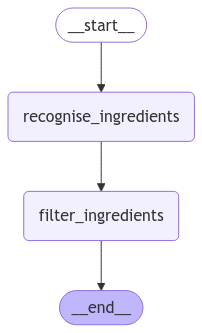

In [10]:
from IPython.display import Image, display 

display(Image(compiled_ingredient_graph.get_graph().draw_mermaid_png()))

In [11]:
# Filter recipes based on user preferences
def filter_recipe(state: OverallRecipeState):
    if not state['recipe_text']:
        return {"filtered_recipes": {}}
    
    messages = [
        {"role": "system", "content": "You are a food expert ensuring that recipes is detailed and match user preferences."},
        {"role": "user", "content": f"""
            You have received the following recipes:
            {state['recipe_text']}
            
            The user has the following preferences:
            - Dietary Preference: {state['preferences']['Dietary Preference']}
            - Recipe Style: {state['preferences']['Recipe Style']}
            - Seasoning Preference: {state['preferences']['Seasoning Preference']}
            - Cooking Time: {state['preferences']['Cooking Time']}
            - Difficulty Level: {state['preferences']['Difficulty Level']}
            
            Review each recipe paying close attention with the ingredients list and the user preferences.
            If any recipes contain non-compliant ingredients or do not match with the user preferences, remove them.
            If you think that there is any missing steps in the recipe, add them to make it more detailed.
            
            Format the response as a JSON object containing only the recipes that pass:
            {{
                "recipe 1": {{
                    "Dish Name": "[Dish Name]",
                    "Ingredients": ["ingredient1", "ingredient2", "ingredient3"],
                    "Instructions": [
                        "Step 1: ...",
                        "Step 2: ...",
                        "Step 3: ..."
                    ]
                }},
                "recipe 2": {{ ... }},
                "recipe 3": {{ ... }}
            }}
            
            If no recipes match, return an empty JSON object: `{{}}`
        """}
    ]

    response = llm.invoke(messages)
    filtered_recipes = response.content if hasattr(response, "content") else "{}"

#  Generate recipe
def get_recipes(state: OverallRecipeState):
    messages = [
        {"role": "system", "content": "You are a professional chef who suggests multiple recipes based on available ingredients."},
        {"role": "user", "content": f"""
            I have the following ingredients available: {', '.join(state['ingredients'])}.
            I have a dietary preference of {state['preferences']['Dietary Preference']}.
            I prefer {state['preferences']['Recipe Style']} cooking style with {state['preferences']['Seasoning Preference']} level of seasoning/spices.
            I would like the cooking time to be around {state['preferences']['Cooking Time']}.
            I would like the cooking difficulty to be {state['preferences']['Difficulty Level']}.
            
            Suggest **three different dishes** I can cook using some of these ingredients.
            - Each recipe should use **a reasonable selection of the provided ingredients**, but does not need to include every single one.
            - Ensure that each recipe makes sense and is practical to cook.
            - Include the required ingredient amount for one serving.
            - If an important ingredient is missing, feel free to mention it as an optional ingredient.

            Format the response strictly as a JSON dictionary like this:
            {{
                "recipe 1": {{
                    "Dish Name": "[Dish Name]",
                    "Ingredients": ["ingredient1", "ingredient2", "ingredient3"],  # Do not use all ingredients, just relevant ones
                    "Instructions": [
                        "Step 1: ...",
                        "Step 2: ...",
                        "Step 3: ..."
                    ]
                }},
                "recipe 2": {{
                    "Dish Name": "[Dish Name]",
                    "Ingredients": ["ingredient1", "ingredient2", "ingredient3"],  # Select only essential ingredients
                    "Instructions": [
                        "Step 1: ...",
                        "Step 2: ...",
                        "Step 3: ..."
                    ]
                }},
                "recipe 3": {{
                    "Dish Name": "[Dish Name]",
                    "Ingredients": ["ingredient1", "ingredient2", "ingredient3"],  # Allow variation
                    "Instructions": [
                        "Step 1: ...",
                        "Step 2: ...",
                        "Step 3: ..."
                    ]
                }}
            }}

            - Ensure the response is a valid JSON object with **no additional explanations**.
            """}
    ]

    response = llm.invoke(messages)
    print(messages)
    return {"recipe_text": response.content}

In [14]:
recipe_graph = StateGraph(OverallRecipeState)
recipe_graph.add_node("generate_recipes", RunnableLambda(get_recipes))
recipe_graph.add_node("filter_recipes", RunnableLambda(filter_recipe))  #  New node
recipe_graph.add_edge("generate_recipes", "filter_recipes")  #  Filter after generating
recipe_graph.add_edge("filter_recipes", END)
recipe_graph.set_entry_point("generate_recipes")
compiled_recipe_graph = recipe_graph.compile()

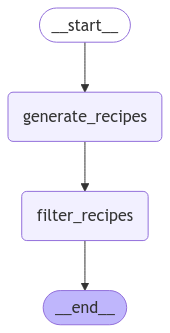

In [15]:
display(Image(compiled_recipe_graph.get_graph().draw_mermaid_png()))